## Import libraries

In [1]:
import pandas as pd
import numpy as np
from rdkit.Chem import Descriptors, Lipinski
from rdkit import Chem
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm.notebook import tqdm
from common import start_pipeline, tidy, select_cols, add_bioactivity, lipinski, normalize_standard_value, pIC50, save_fig
from scipy import stats

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
%config InlineBackend.figure_format='retina'


## Load data

In [2]:
target_HepG2 = pd.read_csv('./data/strigolactone_target_HepG2.csv')
target_HepG2.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,38273,[],CHEMBL881719,The compound was tested for inhibition of chol...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HepG2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.1
1,NaN,44218,[],CHEMBL881719,The compound was tested for inhibition of chol...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HepG2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.1
2,NaN,47846,[],CHEMBL824182,The compound was tested for inhibition of chol...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HepG2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,1.0
3,NaN,74264,[],CHEMBL695846,Compound was tested in vitro for growth inhibi...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HepG2,9606,NaN,NaN,IC50,ug ml-1,UO_0000274,NaN,10.0
4,NaN,78722,[],CHEMBL695847,Compound was tested in vitro for growth inhibi...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HepG2,9606,NaN,NaN,IC50,ug ml-1,UO_0000274,NaN,10.0


In [3]:
target_HepG2.tail()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
20477,NaN,20712344,[],CHEMBL4629308,Cytotoxicity against human HepG2 cells assesse...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HepG2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.0
20478,NaN,20712348,[],CHEMBL4629308,Cytotoxicity against human HepG2 cells assesse...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HepG2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.0
20479,NaN,20712352,[],CHEMBL4629308,Cytotoxicity against human HepG2 cells assesse...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HepG2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,50.0
20480,NaN,20713305,[],CHEMBL4629707,Cytotoxicity against human HepG2 cells after 4...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HepG2,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,100.0
20481,NaN,20719209,[],CHEMBL4509238,Liver HepG2 cell line MDS Pharma Services Prol...,F,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,HepG2,9606,NaN,NaN,IC50,µM,NaN,NaN,3.1


In [4]:
target_HepG2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20482 entries, 0 to 20481
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   activity_comment           534 non-null    object 
 1   activity_id                20482 non-null  int64  
 2   activity_properties        20482 non-null  object 
 3   assay_chembl_id            20482 non-null  object 
 4   assay_description          20482 non-null  object 
 5   assay_type                 20482 non-null  object 
 6   assay_variant_accession    0 non-null      float64
 7   assay_variant_mutation     0 non-null      float64
 8   bao_endpoint               20482 non-null  object 
 9   bao_format                 20482 non-null  object 
 10  bao_label                  20482 non-null  object 
 11  canonical_smiles           20479 non-null  object 
 12  data_validity_comment      1462 non-null   object 
 13  data_validity_description  1462 non-null   obj

## Tidy data

In [5]:
tidy_target_HepG2 = (target_HepG2
                     .pipe(start_pipeline)
                     .pipe(tidy)
                     .pipe(select_cols)
                     .pipe(add_bioactivity)
                     .pipe(lipinski)
                     .pipe(normalize_standard_value)
                     .pipe(pIC50))

/Users/jeraime/Documents/strigolactone_anticancer_target/common.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['standard_value'] = df['standard_value'].astype(float)


In [6]:
tidy_target_HepG2.head()

,molecule_chembl_id,cleaned_canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL39380,COC(=O)CC(O)CP(=O)([O-])CCc1c(Cl)cc(Cl)cc1OCc1...,active,460.270,3.6773,1.0,6.0,7.0
1,CHEMBL39003,CC(C)(C)C(=O)OCOC(=O)CC(O)CP(=O)(CCc1c(Cl)cc(C...,active,675.539,6.7974,1.0,10.0,7.0
2,CHEMBL39102,O=C(O)C[C@H](O)CP(=O)(O)CCc1c(Cl)cc(Cl)cc1OCc1...,active,447.251,4.2209,3.0,4.0,6.0
3,CHEMBL162083,O=S(=O)(CC#C/C=C\C#CCO)c1ccccc1,active,260.314,1.0156,1.0,3.0,8.0
4,CHEMBL350898,COc1ccc(S(=O)(=O)CC#C/C=C\C#CCO)cc1,active,290.340,1.0242,1.0,4.0,8.0


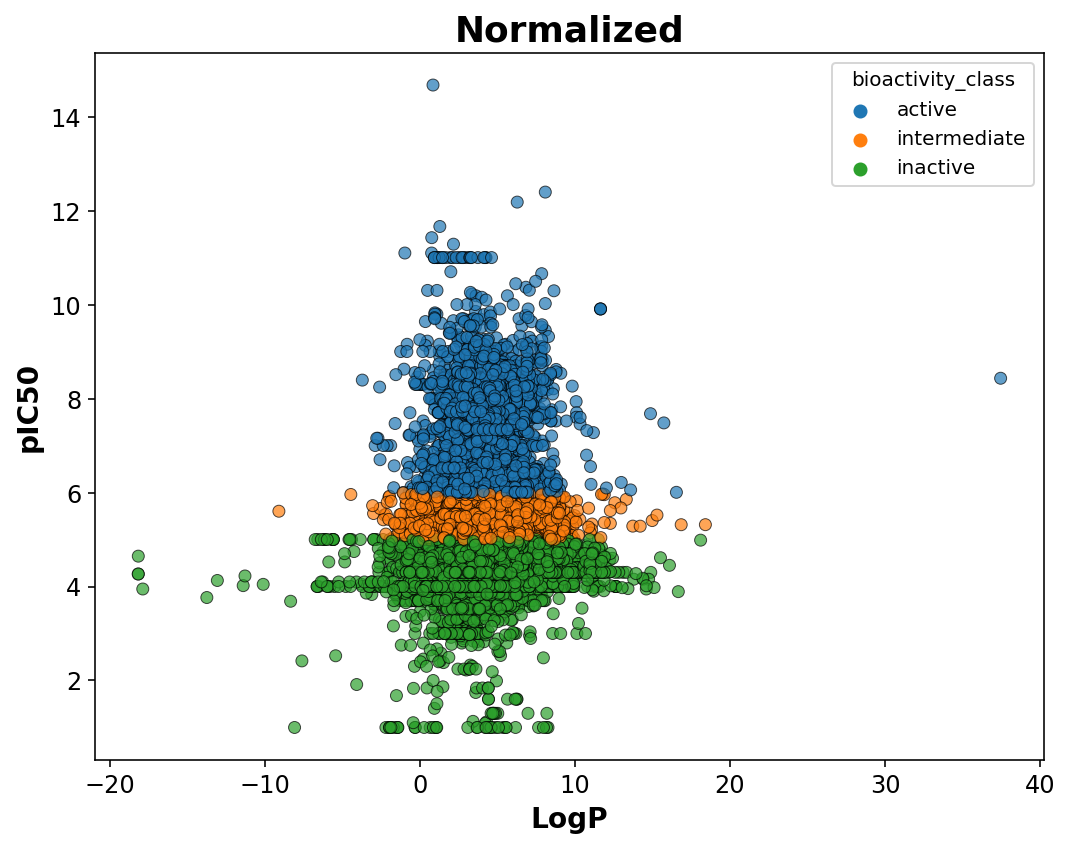

In [15]:
# Plot IC50 v LogP
plt.figure(figsize=(8.5,6.5))
sns.scatterplot(x="LogP",
                y="pIC50",
                data=tidy_target_HepG2,
                hue="bioactivity_class",
                edgecolor="black",
                alpha=0.7
               )
plt.xlabel("LogP", fontsize=14, fontweight="bold")
plt.ylabel("pIC50", fontsize=14, fontweight="bold")
# plt.legend(loc='lower right', bbox_to_anchor=(0.5, 0., 0.5, 0.5), borderaxespad=0)
plt.title('Normalized', fontsize=18, fontweight="bold")
# plt.savefig('Normalized_pIC50.png', format='png', bbox_inches='tight', pad_inches=0, dpi=1200)
plt.show()

In [8]:
tidy_target_HepG2['bioactivity_class'].value_counts()

inactive        10982
intermediate     4085
active           3167
Name: bioactivity_class, dtype: int64

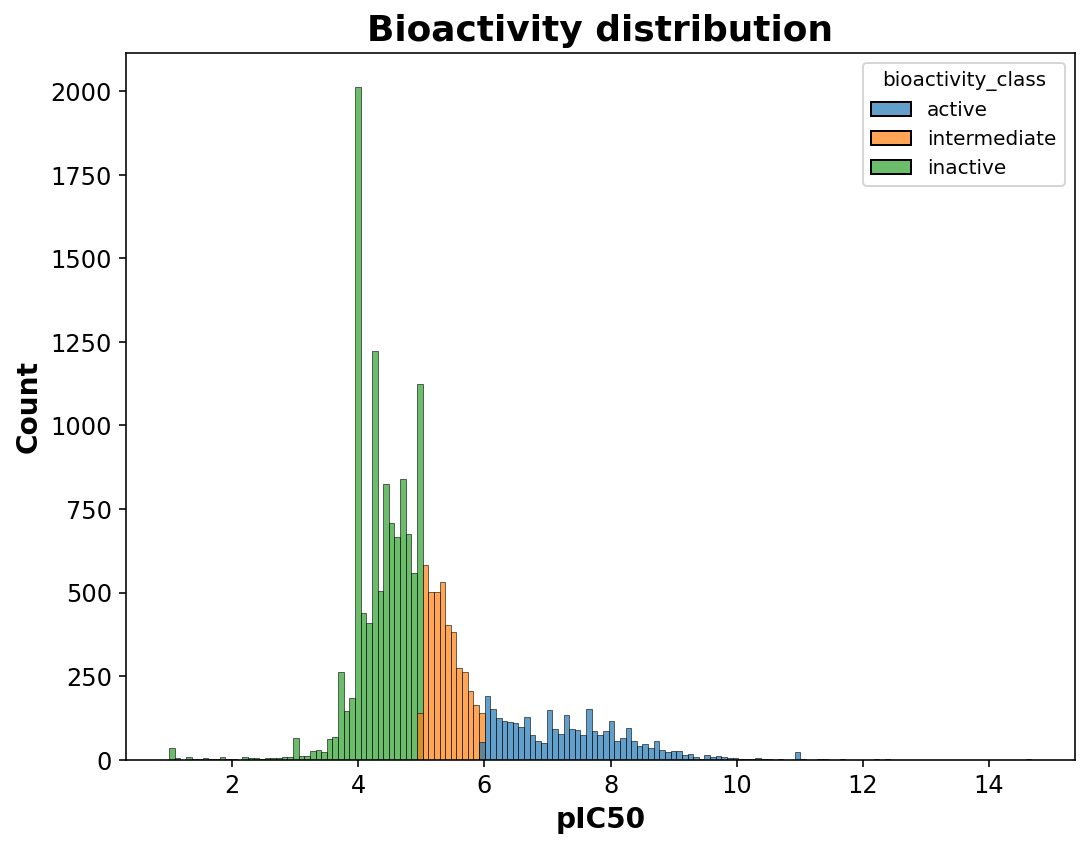

In [9]:
plt.figure(figsize=(8.5,6.5))
sns.histplot(x='pIC50',
             data=tidy_target_HepG2,
             hue="bioactivity_class",
             edgecolor="black",
             alpha=0.7
            )

plt.xlabel("pIC50", fontsize=14, fontweight="bold")
plt.ylabel("Count", fontsize=14, fontweight="bold")
plt.title('Bioactivity distribution', fontsize=18, fontweight="bold")
# plt.savefig('Bioactivity_distribution.png', format='png', bbox_inches='tight', pad_inches=0, dpi=1200)
plt.show()

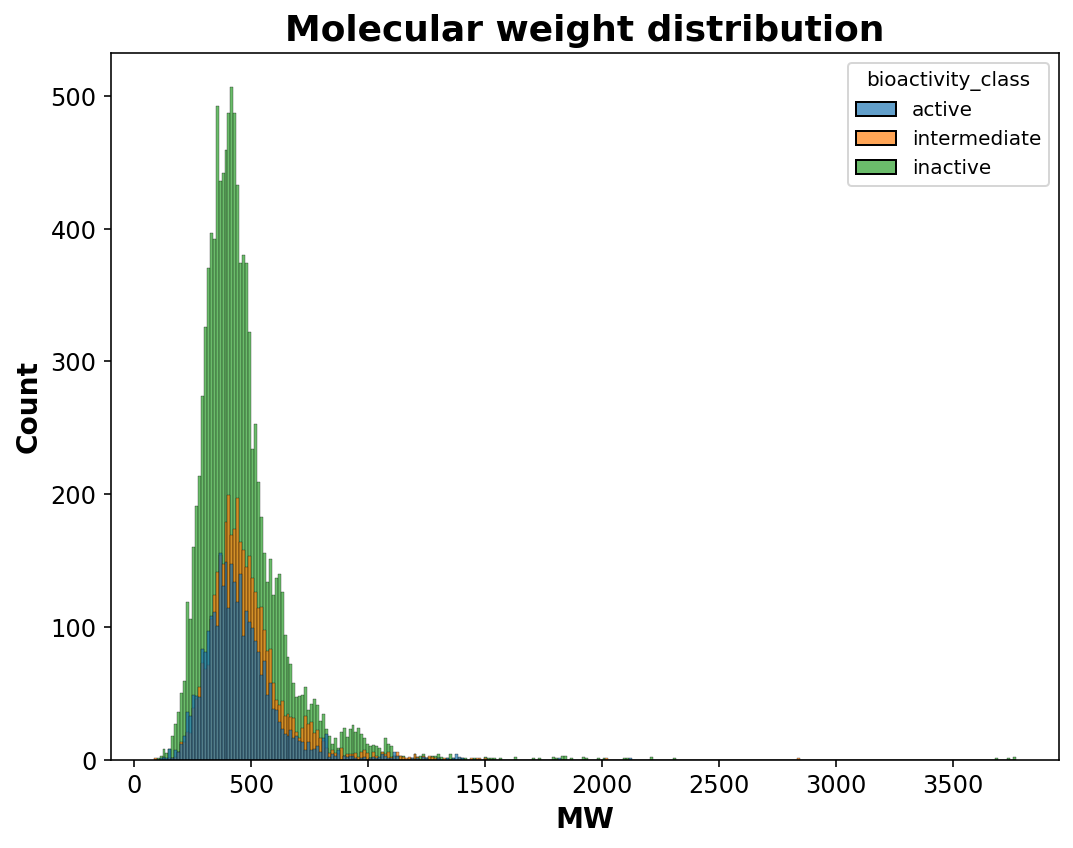

In [10]:
plt.figure(figsize=(8.5,6.5))
sns.histplot(x='MW',
             data=tidy_target_HepG2,
             hue="bioactivity_class",
             edgecolor="black",
             alpha=0.7
            )

plt.xlabel("MW", fontsize=14, fontweight="bold")
plt.ylabel("Count", fontsize=14, fontweight="bold")
plt.title('Molecular weight distribution', fontsize=18, fontweight="bold")
plt.show()

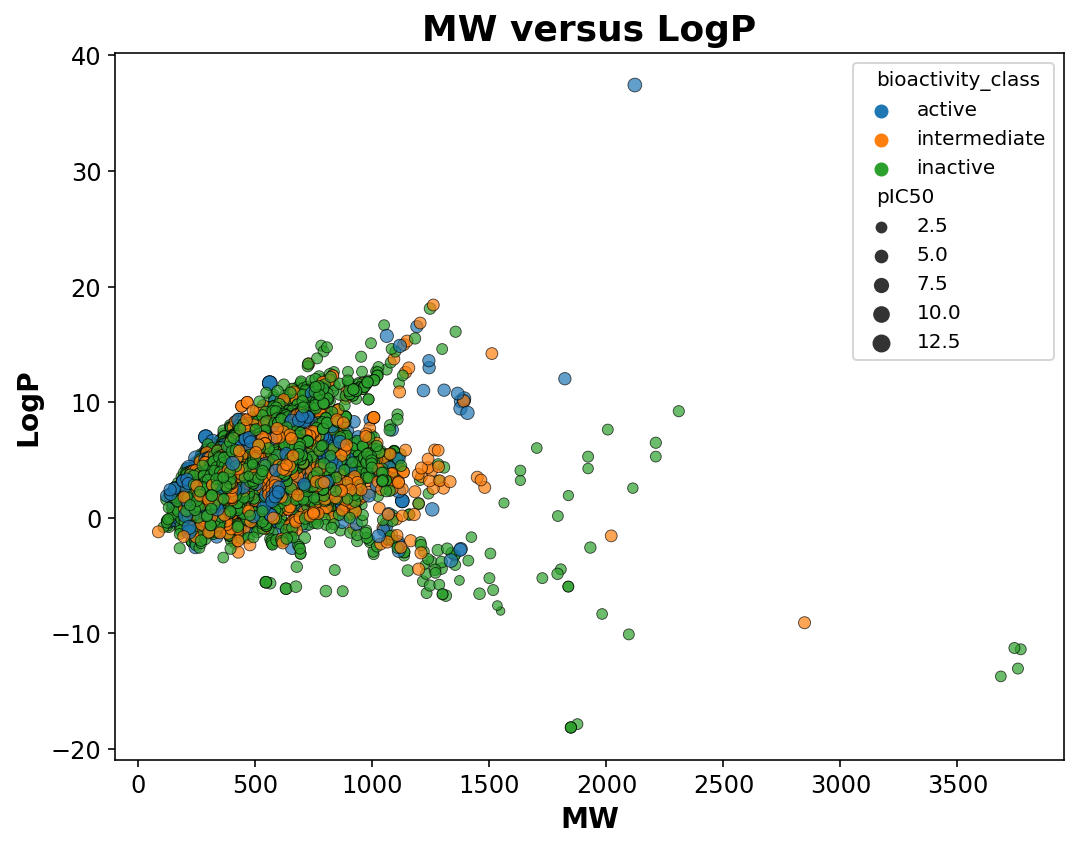

In [11]:
plt.figure(figsize=(8.5, 6.5))

sns.scatterplot(x="MW",
                y="LogP",
                data=tidy_target_HepG2,
                hue="bioactivity_class",
                size="pIC50",
                edgecolor="black",
                alpha=0.7
)

plt.xlabel("MW", fontsize=14, fontweight="bold")
plt.ylabel("LogP", fontsize=14, fontweight="bold")
plt.title('MW versus LogP', fontsize=18, fontweight="bold")
# plt.savefig('MW versus LogP.png', format='png', bbox_inches='tight', pad_inches=0, dpi=1200)
plt.show()

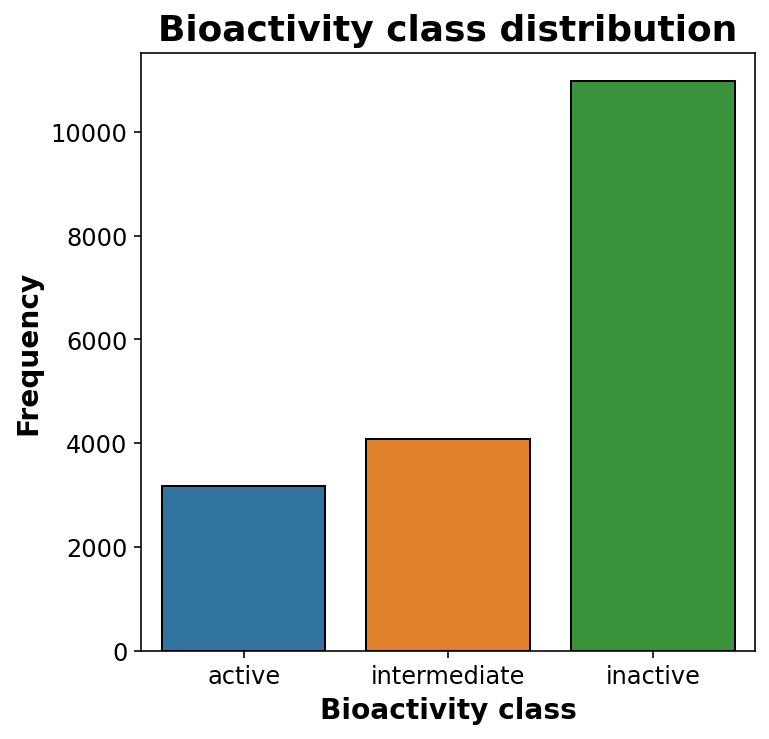

In [14]:
plt.figure(figsize=(5.5,5.5))

sns.countplot(x="bioactivity_class",
              data=tidy_target_HepG2,
              edgecolor="black")

plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("Frequency", fontsize=14, fontweight="bold")
plt.title('Bioactivity class distribution', fontsize=18, fontweight="bold")
# plt.savefig('Bioactivity class distribution.png', format='png', bbox_inches='tight', pad_inches=0, dpi=1200)
plt.show()

In [19]:
tidy_target_HepG2.shape

(18234, 8)

In [13]:
tidy_target_HepG2.to_csv('./data/tidy_target_HepG2_3classes.csv', index=False)

## Removing the `intermediate` bioactivity class

In [14]:
#We will remove the intermediate class from our dataset.

tidy_target_HepG2_2classes = tidy_target_HepG2.loc[tidy_target_HepG2["bioactivity_class"] != "intermediate"]
tidy_target_HepG2_2classes.head()

,molecule_chembl_id,cleaned_canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL39380,COC(=O)CC(O)CP(=O)([O-])CCc1c(Cl)cc(Cl)cc1OCc1...,active,460.270,3.6773,1.0,6.0,7.0
1,CHEMBL39003,CC(C)(C)C(=O)OCOC(=O)CC(O)CP(=O)(CCc1c(Cl)cc(C...,active,675.539,6.7974,1.0,10.0,7.0
2,CHEMBL39102,O=C(O)C[C@H](O)CP(=O)(O)CCc1c(Cl)cc(Cl)cc1OCc1...,active,447.251,4.2209,3.0,4.0,6.0
3,CHEMBL162083,O=S(=O)(CC#C/C=C\C#CCO)c1ccccc1,active,260.314,1.0156,1.0,3.0,8.0
4,CHEMBL350898,COc1ccc(S(=O)(=O)CC#C/C=C\C#CCO)cc1,active,290.340,1.0242,1.0,4.0,8.0


## Frequency plot of the 2 bioactivity classes

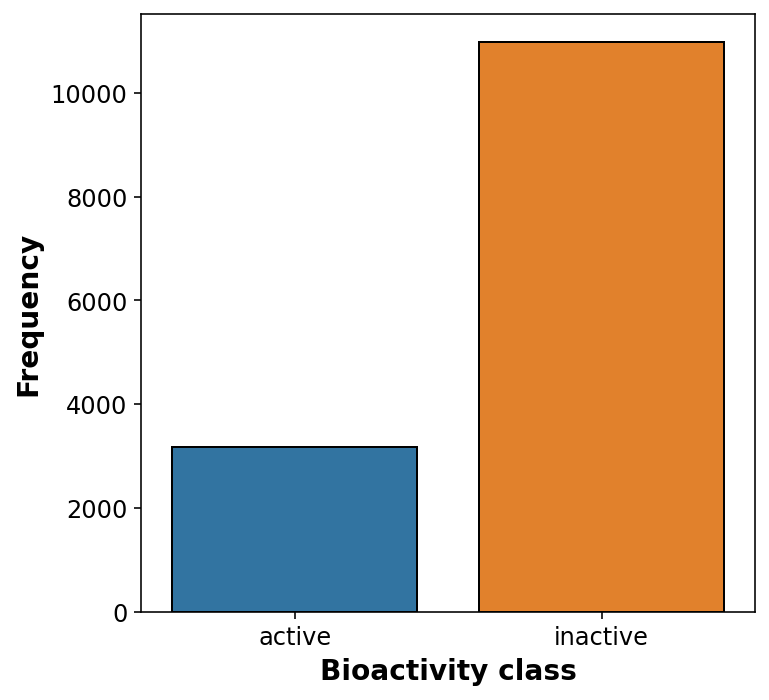

In [15]:
plt.figure(figsize=(5.5,5.5))
sns.countplot(x="bioactivity_class", data=tidy_target_HepG2_2classes, edgecolor="black")
plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("Frequency", fontsize=14, fontweight="bold")
plt.show()

## Scatter plot of MW versus LogP

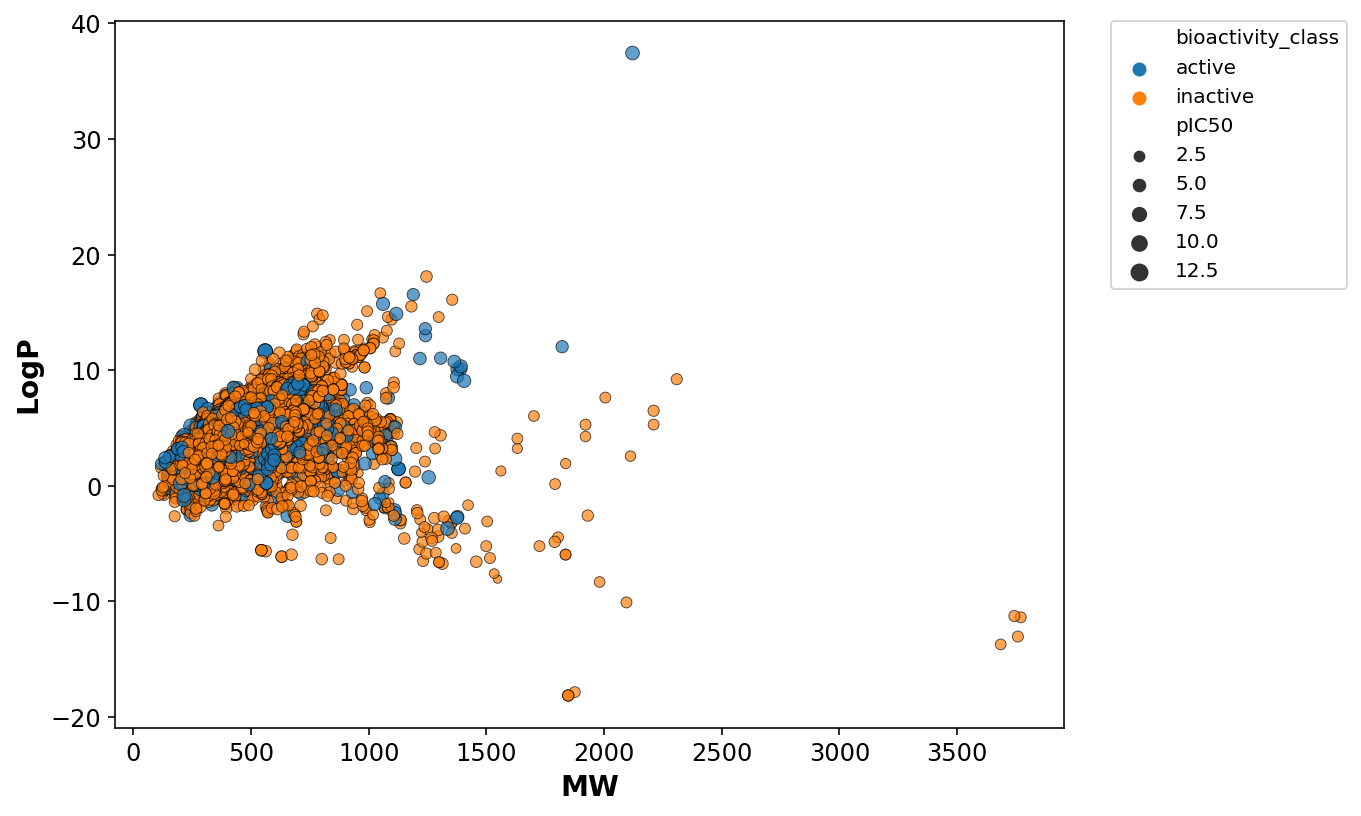

In [16]:
plt.figure(figsize=(8.5, 6.5))

sns.scatterplot(x="MW",
                y="LogP",
                data=tidy_target_HepG2_2classes,
                hue="bioactivity_class",
                size="pIC50",
                edgecolor="black",
                alpha=0.7
)

plt.xlabel("MW", fontsize=14, fontweight="bold")
plt.ylabel("LogP", fontsize=14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

## Box plots

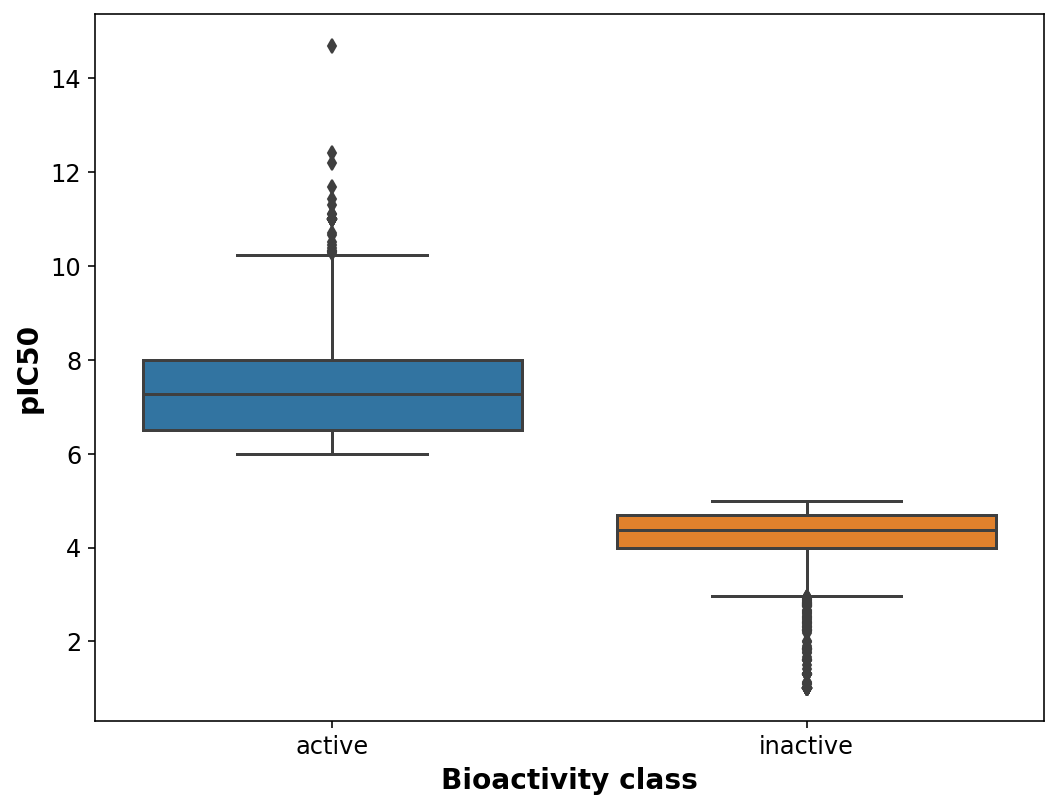

In [17]:
plt.figure(figsize=(8.5, 6.5))
sns.boxplot(x="bioactivity_class", y="pIC50", data=tidy_target_HepG2_2classes)
plt.xlabel("Bioactivity class", fontsize=14, fontweight="bold")
plt.ylabel("pIC50", fontsize=14, fontweight="bold")
plt.show()

In [18]:
# tidy_target_HepG2_2classes.to_csv('./data/tidy_target_HepG2_2classes.csv', index=False)